In [1]:
import torch
from matplotlib import pyplot as plt
from tqdm import tqdm

from survae import SurVAE
from survae.calibrate import calc_cs, plot_histogram, plot_cdf
from survae.data import *
from survae.layer import *

import sklearn

In [31]:
# load digits
digits = sklearn.datasets.load_digits()

# convert relevant information
X = torch.tensor(digits.data)
target = torch.tensor(digits.target)

# create one-hot encoding
y = torch.zeros((len(X), 10))
y[torch.arange(len(X)), target] = 1

# shuffle
rp = torch.randperm(len(X))
X = X[rp]
y = y[rp]

Label: 6


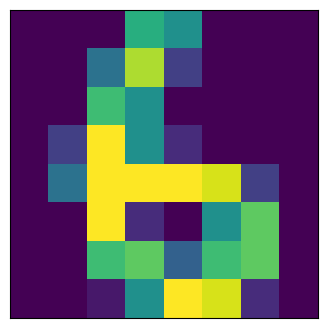

In [109]:
# check that the digits were loaded correctly
_i = 3
plt.figure(figsize=(4, 4))
plt.imshow(X[_i].reshape(8, 8).cpu())
plt.xticks([])
plt.yticks([])
print(f"Label: {y[_i].argmax()}")

In [110]:
# create training subset only consisting of 5's
mask = (y.argmax(dim=1) == 5)
X_5 = X[mask]
y_5 = y[mask]

In [122]:
def train(model, X, y, batch_size, epochs, lr=1e-3, log_count=10):
    optimizer = torch.optim.Adam(params=model.parameters(), lr=lr)
    mse = nn.MSELoss()

    for epoch in tqdm(range(epochs)):
        optimizer.zero_grad()
        r = torch.randperm(len(X))
        x_train = X[r][:batch_size]

        if y is not None:
            y_train = y[r][:batch_size]
            z, ll = model(x_train, y_train, return_log_likelihood=True)
        else:
            z, ll = model(x_train, return_log_likelihood=True)

        # # additional reconstruction loss
        # x_hat = model.backward(z, y_train)
        # loss = (0.5 * torch.sum(z ** 2) - ll + mse_weight * mse(x_train, x_hat)) / batch_size

        loss = (0.5 * torch.sum(z ** 2) - ll) / batch_size
        loss.backward()

        optimizer.step()

    print(f"Final loss: {loss.item():.4f}")

In [113]:
sv_plain = SurVAE(
    [
        [BijectiveLayer(64, [128]), OrthonormalLayer(64)]
        for _ in range(8)
    ],
    "NF"
)

In [120]:
sv_bottleneck = SurVAE(
    [
        [BijectiveLayer(64, [128]), OrthonormalLayer(64)]
        for _ in range(8)
    ] + [
        SliceLayer(64, 8)
    ],
    "NF-bottleneck"
)

In [123]:
train(
    sv_plain,
    X_5,
    None,
    batch_size=1000,
    epochs=100
)

100%|██████████| 100/100 [00:03<00:00, 26.55it/s]

Final loss: 0.6919


In [131]:
train(
    sv_bottleneck,
    X_5,
    None,
    batch_size=1000,
    epochs=8000
)

100%|██████████| 8000/8000 [03:51<00:00, 34.62it/s]

Final loss: -0.2304


In [132]:
n_samples = 20

# sample conditional network
# # target_sample = (torch.rand(n_samples) * 10).int()
# target_sample = torch.tensor([5] * n_samples) # only sample 5's
# y_sample = torch.zeros((n_samples, 10))
# y_sample[torch.arange(n_samples), target_sample] = 1
# X_sample = sv_plain.sample(n_samples, y_sample)


# sample unconditional network
X_sample = sv_bottleneck.sample(n_samples)

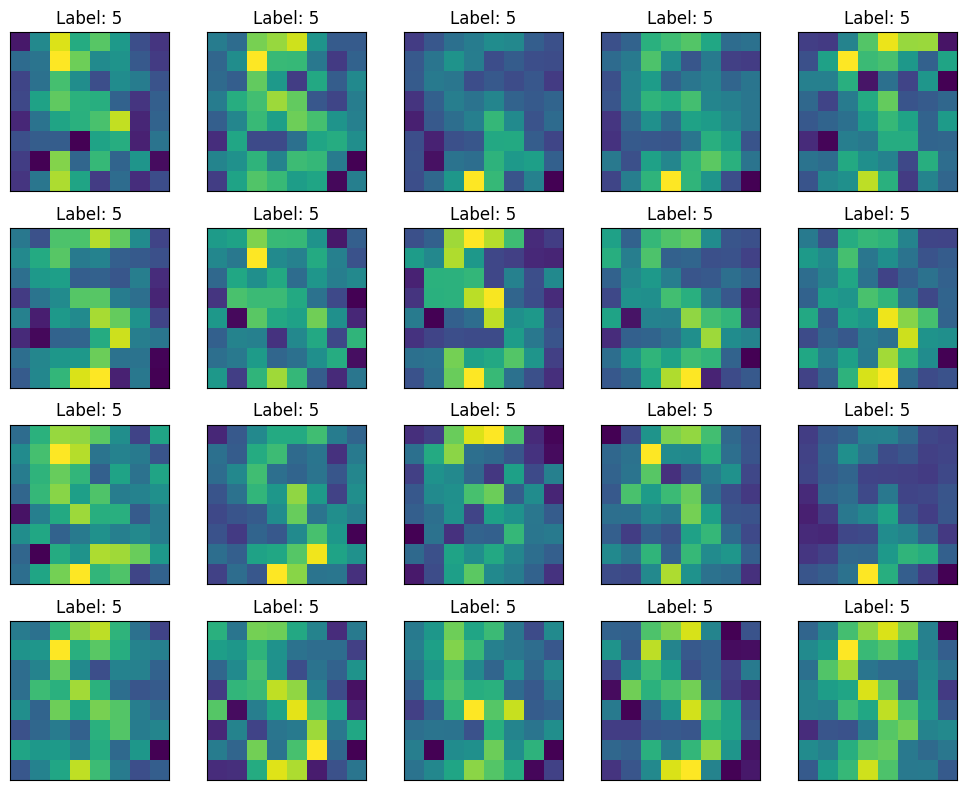

In [133]:
nrows = 4
ncols = 5

fig, ax = plt.subplots(nrows, ncols, figsize=(2 * ncols, 2 * nrows))

for i in range(ncols):
    for k in range(nrows):
        _i = i + ncols * k
        _ax = ax[k][i]
        _ax.imshow(X_sample[_i].reshape(8, 8).cpu())
        if 'y_sample' in locals():
            _ax.set_title(f"Label: {y_sample[_i].argmax()}")
        _ax.set_xticks([])
        _ax.set_yticks([])
plt.tight_layout()